In [1]:
import joblib
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import scanpy as sc
import networkx as nx
import itertools
import anndata
import multiprocessing
import functools

import numpy as np
import scipy.stats as ss
from hba_data import internal_utils as hba_utils
import stream as st

import joblib

from pynndescent import NNDescent


In [2]:
class PseudoGraph:
    def __init__(self, adata):
        self.adata = adata
        self.leaves = [x for x in adata.uns['flat_tree'].nodes() if adata.uns['flat_tree'].degree(x)==1]
        self.milestone_id_to_alias = nx.get_node_attributes(adata.uns['flat_tree'], 'label')
        self.milestone_alias_to_id = {v:k for k,v in nx.get_node_attributes(adata.uns['flat_tree'], 'label').items()}
        
    def cells_of_path(self, src, tgt):
        path_miles = nx.shortest_path(self.adata.uns['flat_tree'], src, tgt)

        path_ids = [self.adata.uns['flat_tree'].edges[e]['id'] \
                    for e in zip(path_miles, path_miles[1:])]

        orderdict = {s:i for i,s in enumerate(path_ids)}

        t_col = f'{self.milestone_id_to_alias[path_miles[0]]}_pseudotime'


        cells = self.adata.obs[self.adata.obs['branch_id'].isin(orderdict)].copy()
        cells = cells.sort_values(['branch_id', t_col], 
                                  key=lambda x: x.map(orderdict).fillna(x) )
#         cells = pd.concat((cells, adata.obs), axis=1)
        return cells[['branch_id', t_col, ]].copy()

    @staticmethod
    def binning(arr,nbins=20):
        return np.digitize(arr, np.linspace(min(arr), max(arr), nbins) ) 
    
    @staticmethod
    def plot_stream(pathdf, groupby, counton, smooth_sd=1):

        rcounts = pathdf.groupby(groupby)[counton].value_counts()
        rcounts.name = 'count'
        rcounts = rcounts.reset_index().pivot(index=groupby,columns=counton).fillna(0)
        rcounts.columns = rcounts.columns.droplevel()
        
        def gaussian_smooth(x, y, sd):
            weights = np.array([ss.norm.pdf(x, m, sd) for m in x])
            weights = weights / weights.sum(1)
            return (weights * y).sum(1)     

        smoothed = [gaussian_smooth(rcounts.index, y_, smooth_sd) for y_ in rcounts.T.values]
        smoothed = pd.DataFrame(np.array(smoothed), index=rcounts.columns, columns=rcounts.index).T
#         smoothed = np.array(smoothed)
        return rcounts, smoothed


In [3]:
ct = 'MSN_D1'
regs = 'BN_BF'

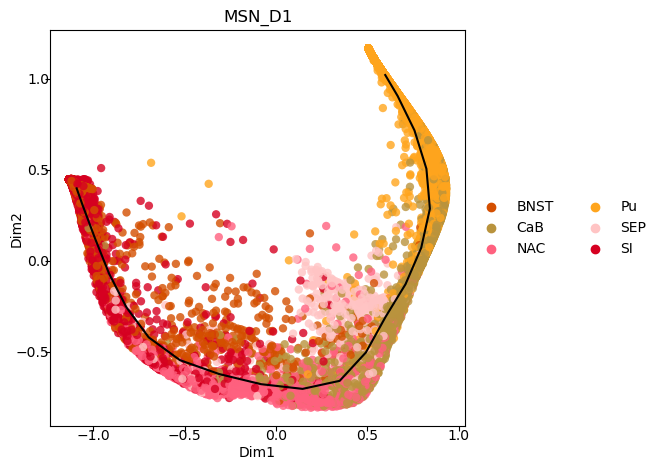

In [4]:
ad = joblib.load(f'../regional-axes/stream/rlt/{ct}.{regs}.joblib')
ad.uns['Region_color']=hba_utils.Region.region_palette()

#embeding
st.plot_dimension_reduction(ad,color=['Region'],n_components=2,
                            show_graph=True,show_text=False, fig_legend_ncol=2)
plt.title(ct)
plt.show()


In [5]:
#process
pt_cols = ad.obs.columns[ad.obs.columns.str.endswith('_pseudotime')]
pg = PseudoGraph(ad)
src_alias = ad.obs[ad.obs['Region'].isin(['Pu'])][pt_cols].mean().idxmax().replace('_pseudotime','')
# tgt = ad.obs[ad.obs['Region'].isin(['Cla','SI'])][pt_cols].mean().idxmax().replace('_pseudotime','')
# src = 'S0'
tgt_alias = 'S1' if src_alias=='S0' else 'S0'

src = pg.milestone_alias_to_id[src_alias]
tgt = pg.milestone_alias_to_id[tgt_alias]

pathdf = pg.cells_of_path(src,tgt)
t_col = pathdf.columns[-1]
tb_col = f'{t_col}_bin'
pathdf[tb_col] = pg.binning(pathdf[t_col])
pathdf['Region']=ad.obs['Region']



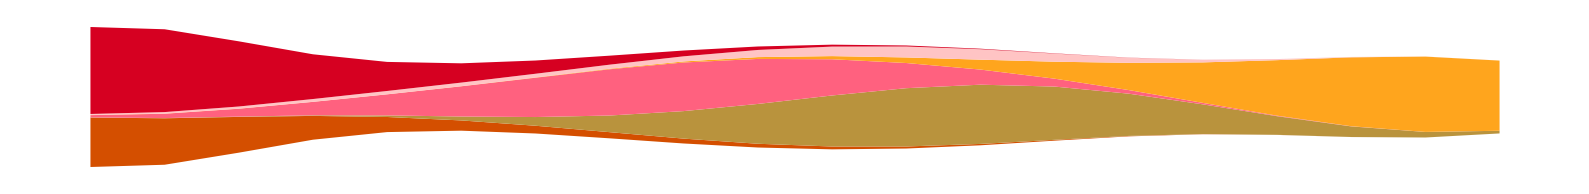

In [6]:
## river plot

rcounts, smoothed = pg.plot_stream(pathdf, tb_col, 'Region', 2)

plt.figure(figsize=(10,1),dpi=200)
plt.stackplot(smoothed.index, smoothed.T, baseline="sym", 
              colors=smoothed.columns.map(hba_utils.Region.region_palette()),
              labels=smoothed.columns
             )
# plt.gca().set_aspect(0.02)
# plt.title(ct)
plt.axis('off')
plt.show()

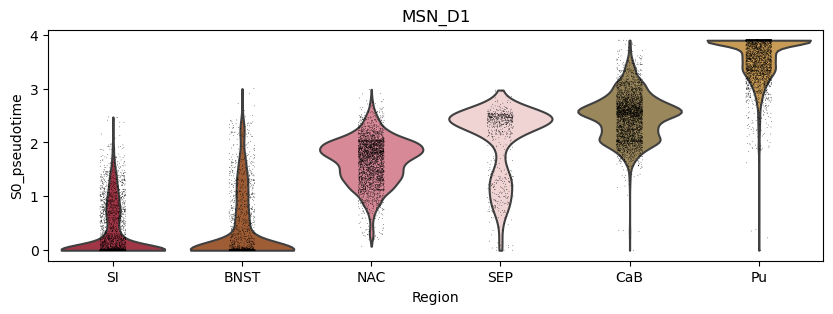

In [7]:
## pt violin plot

plt.figure(figsize=(10,3))
order = pathdf.groupby('Region')[t_col].apply(lambda x: x[len(x)//4:len(x)*3//4].mean()).sort_values().index
sns.violinplot(data=pathdf, x='Region', y=t_col, 
               cut=0, order=order, 
               palette=hba_utils.Region.region_palette(),
               scale='width', saturation=0.5, inner=None
              )
sns.stripplot(data=pathdf, x='Region', y=t_col, 
              order=order, size=0.5,
#                palette=hba_utils.Region.region_palette(),
              palette=['k']
             )
plt.title(ct)
plt.show()
 

# transfer pseudotime

In [8]:
gene_mc_ad = anndata.read_h5ad(f'/gale/netapp/home/wtian/hba/dataset2/gene_mcds/'
                               f'sorted-normalized/{ct}.CHN.gene.h5ad')
sc.pp.scale(gene_mc_ad)

In [9]:
gene_rna_ad = anndata.read_h5ad(f'../regional-gene.old/RNA/rna.{ct}.h5ad')
int_ad = anndata.read_h5ad('../../MultiModalityIntigration/RNA/vs-DNAm/'
                           'integration-data/mc-rna-atac.neu.filtered.n3011690.h5ad')

In [10]:
mc_cells = int_ad.obs_names.intersection(gene_mc_ad.obs_names).intersection(pathdf.index)
rna_cells = int_ad.obs_names.intersection(gene_rna_ad.obs_names)

In [11]:
# gene_mc_ad = gene_mc_ad[mc_cells]
gene_rna_ad = gene_rna_ad[rna_cells]
subpathdf = pathdf.loc[mc_cells]
int_mc_ad = int_ad[mc_cells]
int_rna_ad = int_ad[rna_cells]

In [12]:
knn_index = NNDescent(int_mc_ad.obsm['X_tsne'])
nbrs, _ = knn_index.query(int_rna_ad.obsm['X_tsne'], k=5)
gene_rna_ad.obs[t_col] = [subpathdf.iloc[nbr][t_col].mean() for nbr in nbrs]
gene_rna_ad.obs[tb_col] = pg.binning(gene_rna_ad.obs[t_col])

/data/wtian/local/miniconda3/envs/stream2/lib/python3.7/site-packages/ipykernel_launcher.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  This is separate from the ipykernel package so we can avoid doing imports until


# process rna mc data

In [13]:
sc.pp.filter_cells(gene_rna_ad, min_genes=100)
sc.pp.filter_genes(gene_rna_ad, min_cells=len(gene_rna_ad)//50)
sc.pp.filter_cells(gene_rna_ad, min_genes=100)
sc.pp.filter_genes(gene_rna_ad, min_cells=len(gene_rna_ad)//50)

sc.pp.normalize_total(gene_rna_ad,target_sum=1e6)
sc.pp.log1p(gene_rna_ad)

In [14]:
gene_mc_df = gene_mc_ad[pathdf.index].to_df()

regional_marker = pd.read_csv('../regional-gene.old/regional-markers.all.csv.gz', index_col=0)
regional_marker = regional_marker.query(f'celltype=="{ct}" and mc_type=="CHN" and pvals<0.01 and scores>20')
gene_mc_df = gene_mc_df.loc[:, gene_mc_df.columns.isin(regional_marker['names'])]

In [15]:
gene_id_convert = dict(zip(gene_mc_df.columns.str.split('.').str[0],gene_mc_df.columns))

gene_rna_ad.var.index = gene_rna_ad.var.index.map(lambda x: gene_id_convert.get(x.split('.')[0], None))

gene_rna_ad = gene_rna_ad[:,~gene_rna_ad.var.index.duplicated(keep=False)]

In [16]:
gene_rna_ad_nonorm = gene_rna_ad.copy()

In [17]:
sc.pp.scale(gene_rna_ad)

/data/wtian/local/miniconda3/envs/stream2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [18]:
genes = gene_rna_ad.var.index.intersection(gene_mc_df.columns)

In [19]:
gene_rna_ad = gene_rna_ad[:,genes]
gene_rna_df = gene_rna_ad.to_df()

In [20]:
gene_mc_df = gene_mc_df[genes]

In [70]:
# rna_region_meta = [ pd.read_csv(fn,index_col=0)['roi'].str.split(' ').str[-1] \
#                    for fn in glob.glob('/gale/netapp/home/wtian/hba/other-dataset/Linnarsson/data/meta/*.meta.csv')]
# rna_region_meta = pd.concat(rna_region_meta).to_frame()

In [72]:
# sel_reg_rename_for_colors_10x = dict(zip(hba_utils.Region.region_palette().keys(),
#                                      hba_utils.Region.region_palette().keys()))
# sel_reg_rename_for_colors_10x.update(
#     {
# #         'A13':'FI',
# #      'A14':'FI',
# #      'A23':'ACC',
# #      'A32':'ACC',
#      'A7':'A5-A7',
#      'BL':'AMY',
#      'BM':'AMY',
# #      'CA1':'HiB',
#      'CA1-2R':'HiB',
# #      'CA1-CA3':'HiB',
#      'CA1C-CA3C':'HiT',
#      'CA1R-CA2R-CA3R':'HiB',
# #      'CA2-3':'HiB',
#      'CA3R':'HiB',
#      'CA4C-DGC':'HiT',
#      'CEN':'AMY',
#      'CMN':'AMY',
# #      'CoA':'AMY',
# #      'DG-CA4':'HiB',
#      'DGR-CA4':'HiB',
#      'DGR-CA4Rpy':'HiB',
#      'Idg\u200b':'Idg',
#      'MD-Re':'MD',
#     }
# )
# rna_region_meta['roi'] = rna_region_meta['roi'].map(sel_reg_rename_for_colors_10x)

# rna_region_meta = rna_region_meta.dropna()

In [21]:
# rna_region_meta.to_csv('rna_region.meta.csv.gz')
rna_region_meta = pd.read_csv('rna_region.meta.csv.gz',index_col=0)

# check gene trend

In [22]:
gene_mc_df[tb_col] = pathdf[tb_col]
gene_mc_df['Region'] = pathdf['Region']

meandf_mc_pt = gene_mc_df.groupby(tb_col).mean()
meandf_mc_reg = gene_mc_df.groupby('Region').mean().loc[order].drop(columns=tb_col)

In [23]:
gene_rna_df[tb_col] = gene_rna_ad.obs[tb_col]
gene_rna_df['Region'] = rna_region_meta['roi']

meandf_rna_pt = gene_rna_df.groupby(tb_col).mean()
meandf_rna_reg = gene_rna_df.groupby('Region').mean().loc[order].drop(columns=tb_col)

In [24]:
ptp_mc_reg = meandf_mc_reg.max()-meandf_mc_reg.min()
ptp_mc_pt = meandf_mc_pt.max()-meandf_mc_pt.min()

In [25]:
rho_mc_reg = meandf_mc_reg.apply(lambda x:np.corrcoef(x,range(len(x)))[0,1])
rho_mc_pt = meandf_mc_pt.apply(lambda x:np.corrcoef(x,range(len(x)))[0,1])

/data/wtian/local/miniconda3/envs/stream2/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/data/wtian/local/miniconda3/envs/stream2/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [26]:
rhobg_mc_reg = meandf_mc_reg.apply(lambda x:np.corrcoef(x,np.random.choice(range(len(x)), len(x), replace=False))[0,1],)
rhobg_mc_pt = meandf_mc_pt.apply(lambda x:np.corrcoef(x,np.random.choice(range(len(x)), len(x), replace=False))[0,1],)


In [27]:
ptp_rna_reg = meandf_rna_reg.max()-meandf_rna_reg.min()
ptp_rna_pt = meandf_rna_pt.max()-meandf_rna_pt.min()

In [28]:
rho_rna_reg = meandf_rna_reg.apply(lambda x:np.corrcoef(x,range(len(x)))[0,1],)
rho_rna_pt = meandf_rna_pt.apply(lambda x:np.corrcoef(x,range(len(x)))[0,1],)

In [29]:
rhobg_rna_reg = meandf_rna_reg.apply(lambda x:np.corrcoef(x,np.random.choice(range(len(x)), len(x), replace=False))[0,1],)
rhobg_rna_pt = meandf_rna_pt.apply(lambda x:np.corrcoef(x,np.random.choice(range(len(x)), len(x), replace=False))[0,1],)


/data/wtian/local/miniconda3/envs/stream2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/data/wtian/local/miniconda3/envs/stream2/lib/python3.7/site-packages/seaborn/axisgrid.py:1740: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()
/data/wtian/local/miniconda3/envs/stream2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/data/wtian/local/miniconda3/envs/stream2/lib/python3.7/s

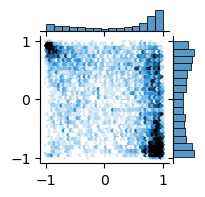

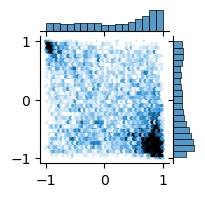

In [30]:
sns.jointplot(rho_mc_reg, rho_rna_reg,kind='hex',gridsize=50,vmax=10,height=2)
sns.jointplot(rho_mc_pt, rho_rna_pt,kind='hex',gridsize=50,vmax=10,height=2)

/data/wtian/local/miniconda3/envs/stream2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/data/wtian/local/miniconda3/envs/stream2/lib/python3.7/site-packages/seaborn/axisgrid.py:1740: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()
/data/wtian/local/miniconda3/envs/stream2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/data/wtian/local/miniconda3/envs/stream2/lib/python3.7/s

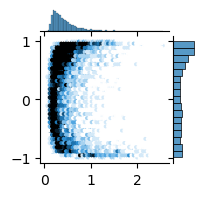

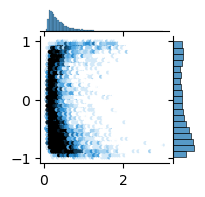

In [31]:
sns.jointplot(ptp_mc_pt, rho_mc_pt,kind='hex',gridsize=50,vmax=10,height=2)
sns.jointplot(ptp_rna_pt, rho_rna_pt,kind='hex',gridsize=50,vmax=10,height=2)


In [32]:
def critival_value(pos_arr, neg_arr, alpha=0.05):
    _pos_arr = np.array(pos_arr).flatten()
    _neg_arr = np.array(neg_arr).flatten()
    n_pos = len(_pos_arr)
    n_neg = len(_neg_arr)
    if n_pos > n_neg:
        _neg_arr = np.hstack((_neg_arr, np.random.choice(_neg_arr, n_pos-n_neg) ))
    elif n_pos < n_neg:
        _pos_arr = np.hstack((_pos_arr, np.random.choice(_pos_arr, n_neg-n_pos) ))
    
    assert len(_pos_arr)==len(_neg_arr)
    fdr = 1-ss.rankdata(-_pos_arr)/ss.rankdata(-np.hstack((_pos_arr, _neg_arr)))[:len(_pos_arr)]
    fdr[fdr<alpha]=0
    
    cv = _pos_arr[fdr.argmin()]
#     print(cv)
    return cv


/data/wtian/local/miniconda3/envs/stream2/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/wtian/local/miniconda3/envs/stream2/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.6090838462718126 -0.8461776427979439


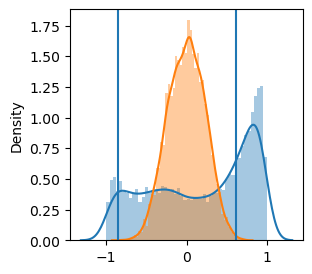

In [33]:
plt.figure(figsize=(3,3))
sns.distplot(rho_mc_pt, bins=50)
sns.distplot(rhobg_mc_pt, bins=50)
cv_mc_pos = critival_value(rho_mc_pt, rhobg_mc_pt)
cv_mc_neg = -critival_value(-rho_mc_pt, -rhobg_mc_pt)

plt.axvline(cv_mc_pos)
plt.axvline(cv_mc_neg)
print(cv_mc_pos,cv_mc_neg)

/data/wtian/local/miniconda3/envs/stream2/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/wtian/local/miniconda3/envs/stream2/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.7454700667742284 -0.4970031323408971


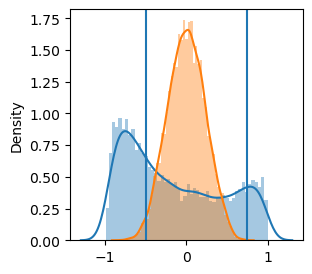

In [34]:
plt.figure(figsize=(3,3))
sns.distplot(rho_rna_pt, bins=50)
sns.distplot(rhobg_rna_pt, bins=50)
cv_rna_pos = critival_value(rho_rna_pt, rhobg_rna_pt)
cv_rna_neg = -critival_value(-rho_rna_pt, -rhobg_rna_pt)

plt.axvline(cv_rna_pos)
plt.axvline(cv_rna_neg)
print(cv_rna_pos,cv_rna_neg)

In [35]:
sig_mc_genes = rho_mc_pt[(rho_mc_pt>=cv_mc_pos)|(rho_mc_pt<=cv_mc_neg)].index
sig_pos_mc_genes = rho_mc_pt[(rho_mc_pt>=cv_mc_pos)].index
sig_neg_mc_genes = rho_mc_pt[(rho_mc_pt<=cv_mc_neg)].index

sig_mc_gene_names = hba_utils.Gene.get_gene_name(sig_mc_genes)
sig_pos_mc_gene_names = hba_utils.Gene.get_gene_name(sig_pos_mc_genes)
sig_neg_mc_gene_names = hba_utils.Gene.get_gene_name(sig_neg_mc_genes)


In [36]:
sig_rna_genes = rho_rna_pt[(rho_rna_pt>=cv_rna_pos)|(rho_rna_pt<=cv_rna_neg)].index
sig_pos_rna_genes = rho_rna_pt[(rho_rna_pt>=cv_rna_pos)].index
sig_neg_rna_genes = rho_rna_pt[(rho_rna_pt<=cv_rna_neg)].index

sig_rna_gene_names = hba_utils.Gene.get_gene_name(sig_rna_genes)
sig_pos_rna_gene_names = hba_utils.Gene.get_gene_name(sig_pos_rna_genes)
sig_neg_rna_gene_names = hba_utils.Gene.get_gene_name(sig_neg_rna_genes)


In [37]:
sig_both_genes = sig_rna_genes.intersection(sig_mc_genes)

In [38]:
# goi = np.loadtxt('/gale/netapp/home/wtian/hba/analysis/CellTypeDMG/gene-of-interests.list', dtype=str)
# sig_both_genes_oi = hba_utils.Gene.get_gene_id(list(set(hba_utils.Gene.get_gene_name(sig_both_genes))&set(goi)))

In [39]:
sig_mc_gene_avg_expr = pd.Series(np.array(gene_rna_ad_nonorm[:,sig_mc_genes].X.mean(0)).flatten(), 
                                 index = gene_rna_ad_nonorm[:,sig_mc_genes].var_names)

In [40]:
len(sig_mc_genes)

2876

In [41]:
sig_mc_genes_goodrna = sig_mc_genes[(sig_mc_gene_avg_expr>1)]

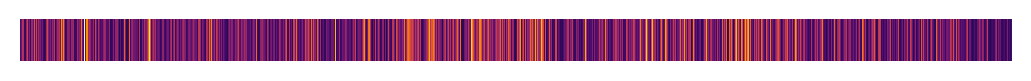

In [42]:
plt.figure(dpi=200)
plt.imshow(np.tile(sig_mc_gene_avg_expr[sig_mc_genes_goodrna].values.reshape(1,-1), (50,1)), 
           vmin=0,vmax=8, cmap='inferno')
# plt.colorbar()
plt.axis('off')
plt.show()

/data/wtian/local/miniconda3/envs/stream2/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/data/wtian/local/miniconda3/envs/stream2/lib/python3.7/site-packages/seaborn/matrix.py:1203: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(**tight_params)


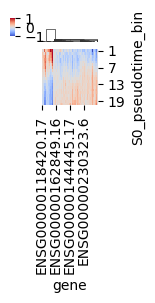

In [43]:
g = sns.clustermap(meandf_mc_pt[sig_mc_genes_goodrna], row_cluster=False, metric='cosine',
                   vmin=-1, vmax=1, cmap='coolwarm',figsize=(1,1))


In [44]:
toplot_mc = meandf_mc_pt[sig_mc_genes_goodrna].iloc[:,g.dendrogram_col.reordered_ind].T
toplot_rna = meandf_rna_pt[sig_mc_genes_goodrna].iloc[:,g.dendrogram_col.reordered_ind].T

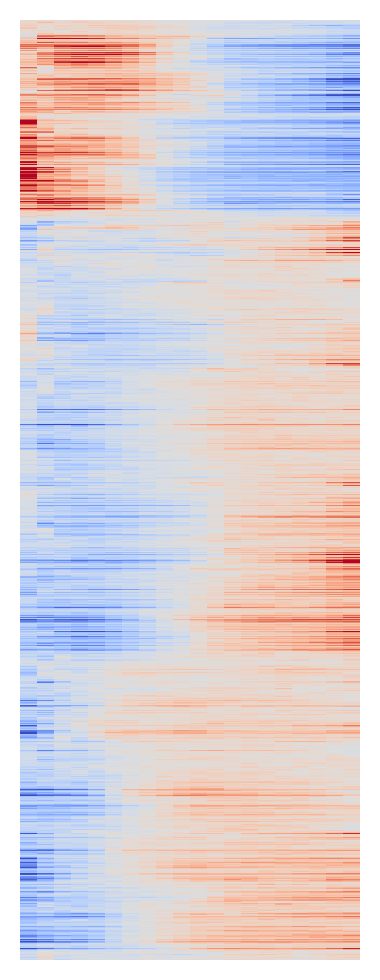

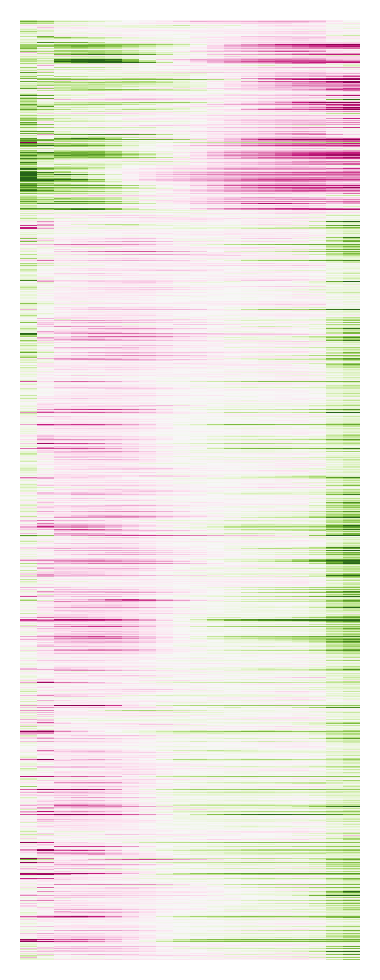

In [45]:
plt.figure(figsize=(2,5),dpi=200)
sns.heatmap(toplot_mc,vmin=-1, vmax=1, cmap='coolwarm',cbar=None)
plt.axis('off')
plt.tight_layout()
plt.savefig(f'{ct}.example.mc.png',bbox_inches='tight', transparent=True)
plt.show()
plt.figure(figsize=(2,5),dpi=200)
sns.heatmap(toplot_rna,vmin=-1, vmax=1, cmap='PiYG_r',cbar=None)
plt.axis('off')
plt.tight_layout()
plt.savefig(f'{ct}.example.rna.png',bbox_inches='tight', transparent=True)
plt.show()


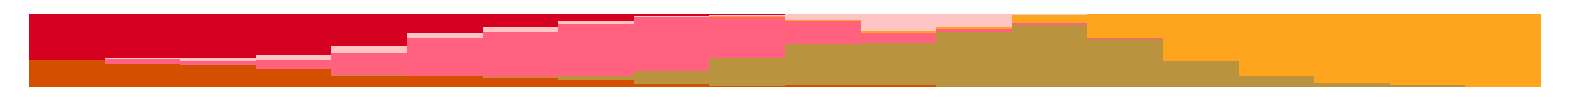

In [46]:
color = [hba_utils.Region.region_palette()[x] for x in sorted(pathdf['Region'].unique())]
plt.figure(figsize=(20,1))
pathdf.groupby(tb_col)['Region'].value_counts(normalize=True).unstack().plot.bar(stacked=True, 
                                                                                 color=color, width=1,
                                                                                 ax=plt.gca(), legend=False)
plt.axis('off')
plt.show()

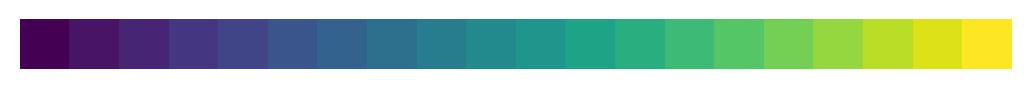

In [47]:
plt.figure(dpi=200)
plt.imshow(np.arange(20).reshape(1,-1),)
plt.axis('off')
plt.show()

In [48]:
np.savetxt(f'{ct}.sig-gene.txt', hba_utils.Gene.get_gene_name(sig_mc_genes), fmt='%s')
np.savetxt(f'{ct}.sig-gene.good-expr.txt', hba_utils.Gene.get_gene_name(sig_mc_genes_goodrna), fmt='%s')
pathdf.to_pickle(f'{ct}.pathdf.pdpkl')